<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2025/blob/main/Week_03/Lab3_Visual_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LAB 3.** Visual Transformers

**Let's start with downloading libraries we did not have on the previous lab.**

In [ ]:
!pip install transformers
!pip install datasets
!pip install --quiet evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
# Pytorch part
import torch
import torch.nn as nn
import torch.utils as utils
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import functional as f

# Hugging Face part
from transformers import Trainer, TrainingArguments
from datasets import load_dataset, Dataset, DatasetDict
from transformers import ViTImageProcessor, ViTForImageClassification

# Other libraries
import random
import evaluate
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

# Disabling WANDB
import wandb
wandb.init(mode='disabled')

As you might know specifically transformers defines the most progress in many ML tasks at the moment. The key and, in theory, almost the only key component of the transformer is the **Multi-Head Attention** layer. Initially when applied to the task of machine translation, it made it possible to take into account the interaction between words located at an arbitrarily large distance in the text, which favorably distinguished the transformer from other translation models and allowed it to take its place in the sun. Formally, this layer is written in terms of the following transformations:

![](https://habrastorage.org/getpro/habr/upload_files/6f5/6a7/56f/6f56a756ff0f1bf515432e682ca1639a.svg)

![](https://habrastorage.org/getpro/habr/upload_files/ff3/a9f/64f/ff3a9f64f8df2adffe643b504e699771.svg)

WHERE

![](https://habrastorage.org/getpro/habr/upload_files/f50/594/979/f50594979e5b53ae125646961ba01755.svg)



[TRANSFORMER (FULL EXPLANATION)](https://jalammar.github.io/illustrated-transformer/) - **RECOMMENDED!**

In this lab session we will go through the most advanced type of computer vision - Transformer-based architecture called Visual Transformer (VT). Specifically we will make practical comparison between CNN and VT models. Our main goal is to get throgh practical application and apply a latter architecture for a practical example (e.g. classification task).

Usually we associate VT models with big pretrained models that consist of millions (or even billions) of parameters making it almost infeasible to train in "home" conditions. In that case we are basically focused on transfer learning that leads us to pipelined solutions to make it possible to finalize a training task at a reasonable time.

First let's recall our previously considered CNN architecture.

In [ ]:
class CNN_advanced(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extraction_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.flatten = nn.Flatten()

        self.classification_block = nn.Sequential(
            nn.Linear(in_features= 4 * 4 * 4 * 4, out_features=10),
        )
        self.out = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feature_extraction_block(x)
        x = self.flatten(x)
        x = self.classification_block(x)
        x = self.out(x)
        return x

Definitely CNN can be considered as an important and fundamental milestone in the world of CV area. As we know CNN has a certain property that makes them so effective in various CV problems - **inductive bias**.

VT is not tied to this property given number of parameteres and data used for training.


1.   It means they are highly scalable (**read why it is the case by yourself**)
2.   Obviously requires a lot of data to train
3.   We can use its ability to solve various CV problems by creating a pipeline based on them

We have already dealt with transfer learning on the previous lab session. We discussed that transfer learning is a good idea when we need to make a step forward in model abilities or when we want to check a hypothesis whether a problem is solvable at least, as it is most likely hard to solve when SOTA models are showing bad results - OR NOT?

From practical point of view it is not that hard to conceptualize a model based on pretrained architectures. Usually we have two strategies:

1.   When we keep pretrained parameters freezed - **transfer learning**
2.   When we retrain all the parameters - **fine-tuning**

First let's prepare our dataset. In this lab we will switch our focus to the Hugging Face library. Here you can also find all the latest versions of most SOTA models, especially transformer-based architectures and surely Large Language Models (LLMs).

Also it includes a huge number of public and custom datasets for different problems associated with Deep Learning, but usually from CV and NLP areas. We can stick with [CIFAR10](https://huggingface.co/datasets/uoft-cs/cifar10), but in that time with a different source for download. However we need to make a couple steps to adapt it for using it with **pytoch** methods. Luckily it is **pretty straightforward**.

Let's download a datset and take a look on its structure.

In [ ]:
dataset = load_dataset('cifar10')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

Unfortunately there is no a defined method for shuffling a data inside any preloaded dataset. But still we can address to the Dataset class inside our loaded data and randomly choose samples using a common indexing. For that we can generate a list of integers and extract samples by using **select** method.

We will take only a minor part of the dataset given a calculation bottleneck associated with transformers.

In [ ]:
random_train = random.choices(range(1, len(dataset['train'])), k = 1000)
random_test = random.choices(range(1, len(dataset['test'])), k = 200)

In [ ]:
train_ds, test_ds = dataset['train'].select(random_train), dataset['test'].select(random_test)

Also we can randomly choose some number of pictures to visually assess pictures themselves.

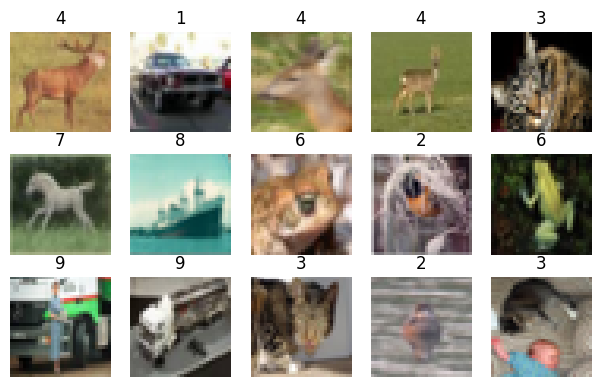

In [ ]:
def show_samples(ds,rows,cols):
    fig = plt.figure(figsize=(cols*1.5, rows*1.5))
    # plotting
    for i in range(rows*cols):
        img = ds['img'][i]
        label = ds['label'][i]
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(train_ds,rows=3,cols=5)

We are dealing with a bit different type of data comparing with original pytorch dataset. So we need to make some sort transformations and manipulations to adapt it for using with torch functions and methods.

First let's arrange our labels. Here you can notice a special type named Long which is inherent for using with NLLoss function.

In [ ]:
train_labels = [torch.tensor(x, dtype=torch.long) for x in train_ds['label']]
test_labels = [torch.tensor(x, dtype=torch.long)  for x in test_ds['label']]

Define transformations required for our images to use it with pytoch models. You can notice that except transforming PIL image to the Tensor foramt we also need to make it as a float, because original images usually are preserved as *uint8* format that we talked about on the previous lab session.

In [ ]:
transform = transforms.Compose([transforms.PILToTensor(),
                               transforms.v2.ToDtype(torch.float32, scale=True),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Applying transformations...

In [ ]:
train_torch = [transform(x) for x in train_ds['img']]
test_torch = [transform(x) for x in test_ds['img']]

Defining Dataloaders...

In [ ]:
dataset_final_train = utils.data.TensorDataset(torch.stack(train_torch), torch.stack(train_labels))
dataloader_train = DataLoader(dataset_final_train, batch_size=32)

dataset_final_test = utils.data.TensorDataset(torch.stack(test_torch), torch.stack(test_labels))
dataloader_test = DataLoader(dataset_final_test, batch_size=32)

Finally we can start training our torch model based on the tranformed Hugging Face dataset...

In [ ]:
def train(model, train_loader, test_loader, optimizer, criterion = torch.nn.NLLLoss(),
          n_epochs = 10, max_epochs_stop = 3):

    # specify loss function
    criterion = criterion

    # specify optimizer
    optimizer = optimizer

    epochs_no_improve = 0
    max_epochs_stop = max_epochs_stop
    test_loss_min = np.Inf

    for epoch in range(1, n_epochs+1):

        # keep track of training and Test loss
        train_loss = 0.0
        test_loss = 0.0

        train_acc = 0
        test_acc = 0



        # TRAIN STEP


        model.train()

        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            # Calculate accuracy (don't forget to modify if you are using Cross-Enthropy and Softmax function)
            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim = 1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            train_acc += accuracy.item()

            print(f'Epoch: {epoch} \t {100 * i / len(train_loader):.2f}% complete.', end = '\r')

        # VALIDATION STEP


        model.eval()
        for data, target in test_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average Test loss
            test_loss += loss.item()

            # Calculate accuracy
            ps = torch.exp(output)
            topk, topclass = ps.topk(1, dim = 1)
            equals = topclass == target.view(*topclass.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            test_acc += accuracy.item()

        # calculate average losses
        train_loss = train_loss/len(train_loader)
        test_loss = test_loss/len(test_loader)

        train_acc = train_acc/len(train_loader)
        test_acc = test_acc/len(test_loader)

        # print training/Test statistics
        print('\nEpoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
            epoch, train_loss, test_loss))
        print(f'Training Accuracy: {100 * train_acc:.2f}%\t Test Accuracy: {100 * test_acc:.2f}%')

        # save model if Test loss has decreased
        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Continue training ...'.format(
            test_loss_min,
            test_loss))
            # torch.save(model.state_dict(), save_file)
            epochs_no_improve = 0
            test_loss_min = test_loss
        else:
            epochs_no_improve += 1
            print(f'{epochs_no_improve} epochs with no improvement.')
            if epochs_no_improve >= max_epochs_stop:
                print('Early Stopping')
                break

In [ ]:
model = CNN_advanced()

n_epochs = 20 # you may increase this number to train in a final model
optimizer = optim.Adam(model.parameters()) # Choosing optimizer. Let's choose classical Adam optimizer
# save_file_name = 'model-cifar.pt' # define name to save weights of our model

In [ ]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    model.cuda()

In [ ]:
train(model, dataloader_train, dataloader_test, optimizer = optimizer, n_epochs = n_epochs)


Epoch: 1 	Training Loss: 2.287472 	Test Loss: 2.229091
Training Accuracy: 11.52%	 Test Accuracy: 17.41%
Test loss decreased (inf --> 2.229091).  Continue training ...
Epoch: 2 	 96.88% complete.
Epoch: 2 	Training Loss: 2.128464 	Test Loss: 1.951525
Training Accuracy: 24.32%	 Test Accuracy: 27.68%
Test loss decreased (2.229091 --> 1.951525).  Continue training ...
Epoch: 3 	 96.88% complete.
Epoch: 3 	Training Loss: 1.944782 	Test Loss: 1.776016
Training Accuracy: 32.13%	 Test Accuracy: 33.48%
Test loss decreased (1.951525 --> 1.776016).  Continue training ...

Epoch: 4 	Training Loss: 1.821200 	Test Loss: 1.690536
Training Accuracy: 36.13%	 Test Accuracy: 39.29%
Test loss decreased (1.776016 --> 1.690536).  Continue training ...
Epoch: 5 	 96.88% complete.
Epoch: 5 	Training Loss: 1.737912 	Test Loss: 1.643543
Training Accuracy: 39.36%	 Test Accuracy: 39.73%
Test loss decreased (1.690536 --> 1.643543).  Continue training ...

Epoch: 6 	Training Loss: 1.677039 	Test Loss: 1.616472
Tra

We might notive that accuracy has dropped significantly comparing with what we have received by using the full dataset.

Now let's switch to **Visual Transformers**. You can check its simpilified architecture on the image below.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vit_architecture.jpg)

If you are a bit familiar with a context of transformers, than you probably should know that before disgesting any kind of samples (like text or images), we need something called Tokenizer for texts and Image Processors for images.

Briefly saying, an image processor is in charge of preparing input features for vision models and post processing their outputs. This includes transformations such as resizing, normalization, and conversion to PyTorch, TensorFlow, Flax and Numpy tensors. It may also include model specific post-processing such as converting logits to segmentation masks.

To apply the right transforms on our images, we will be using [ViTImageProcessor](https://discuss.huggingface.co/t/vitimageprocessor-output-visualization/76335) which will apply the transforms according to the model we will use. We can check its configuration to see what transforms will be applied. You can search an additional information about its properties and tranformations it apllies for input images.

In [ ]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

We would like to know the actual class name, rather than the integer index. We can obtain that by creating a dictionary which maps between integer indices and actual class names (id2label):

In [ ]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
id2label[train_ds['label'][0]]

'airplane'

We can apply various **torch** transformations from the previous lab, but specifically for our **Transformer** architecrure.

In [ ]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([RandomResizedCrop(size),
                             RandomHorizontalFlip(),
                             ToTensor(),
                             normalize])

_val_transforms = Compose([Resize(size),
                           CenterCrop(size),
                           ToTensor(),
                           normalize])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

Applying transformations. Don't forget that they are possible until our data is defined as the [**Dataset**](https://huggingface.co/docs/datasets/v1.2.0/processing.html) class.

In [ ]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

Making DataLoader

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=32)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels torch.Size([32])


Using the special method for downloading the pretrained model

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next Hugging Face uses **TrainingArguments**, which is a class that defines all the attributes needed for the training process. For example, we can define It a folder name, which will be used to save checkpoints, etc.

We also set the argument **remove_unused_columns** to False, because otherwise the "img" column would be removed, which is required for the data transformations.

In [ ]:


metric_name = "accuracy"


args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to=None
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Preparing a special function to assess accuracy of our **transformer model.**

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

As in the previous lab we need to freeze weights of our transformer as we are intereseted to change only the **classifier layer.**

In [ ]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

All the prepared data we need to transfer to a special method called **Trainer**

In [ ]:

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

<ipython-input-131-615cbc4d763a>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Start training our model...

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.224240,0.375000
2,No log,2.208972,0.405000
3,No log,2.195996,0.440000
4,No log,2.184999,0.480000
5,No log,2.175386,0.530000
6,No log,2.167592,0.560000
7,No log,2.161398,0.565000
8,No log,2.157062,0.595000
9,No log,2.154442,0.600000


As you might notice we were able to achieve ~60% accuracy comparing with the initial CNN architecture which is a significant improvement. However, don't forget result can deviate from attempt to attempt with various dataset splits or used parts for training and testing.

But a main disadvantage is time that we need to train such pipeline. Obviously the main bottleneck is comlexity of the classic Multi-Head Self Attention blocks. For that purpose there was proposed **Swin Transformer**

![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/c50/b87/551/c50b875512403f6399510cc736088b76.jpg)

The main feature in this architecture is Window Multi Head Attention Blocks:

![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/b01/d1c/894/b01d1c89427ad597bf59243701faba34.jpg)

Main advatange Swin optimizes the attention process by reducing the normally quadratic complexity VT into linear complexity (with respect to image size).

More details about [Swin Transformer](https://huggingface.co/learn/computer-vision-course/unit3/vision-transformers/swin-transformer)

Let's import necessary libraries and repeat steps we have made previously for the initital transformer model.

In [ ]:
from transformers import AutoImageProcessor, SwinForImageClassification, SwinConfig

In [ ]:
config = SwinConfig.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification")

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=config,
    ignore_mismatched_sizes=True)

image_processor_swin = AutoImageProcessor.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224")

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [ ]:
metric_name = "accuracy"


args = TrainingArguments(
    f"test-cifar-10-swin",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to=None
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [ ]:
trainer_swin = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=image_processor_swin,
)

<ipython-input-119-e8a5b1bcaecf>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_swin = Trainer(


In [ ]:
 for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [ ]:
trainer_swin.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.285081,0.125000
2,No log,2.261656,0.160000
3,No log,2.239467,0.190000
4,No log,2.218642,0.210000
5,No log,2.200351,0.240000
6,No log,2.182510,0.250000
7,No log,2.166693,0.275000
8,No log,2.151813,0.290000
9,No log,2.138007,0.310000
10,No log,2.125889,0.320000


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.285081,0.125000
2,No log,2.261656,0.160000
3,No log,2.239467,0.190000
4,No log,2.218642,0.210000
5,No log,2.200351,0.240000
6,No log,2.182510,0.250000
7,No log,2.166693,0.275000
8,No log,2.151813,0.290000
9,No log,2.138007,0.310000
10,No log,2.125889,0.320000


That's it for today...

---

# **Home task**









## Task 1

You have to find two different datasets from Hugging Face library and train two different Visual Transformer-based architectures. It is up to you what architectures to choose using tags and categories provided by the library. In order to find them you can use [Hugging Face model search](https://huggingface.co/models). This is an [example](https://huggingface.co/models?pipeline_tag=image-classification&p=1&sort=trending&search=vit).

You can stick with CPU, but don't hesitate to use GPU runtime. You are allowed to use any computation environment - Colab, Kaggle, a university's cluster or your own. You can go through documentation to get to know how GPU training is done. Don't forget to provide a link with computations in that case.


In [1]:
# ***YOUR CODE***

## Task 2

Visual Transformers can be also used for image segmentation. You have to find a transformer model to complete the segmentation task of the provided picture. You have been provided function to show the result of the segmentation, but you can change if it is needed. A Chosen model should segment as the same or better on the provided image.


In [ ]:
from transformers import MaskFormerForInstanceSegmentation
from PIL import Image
import requests

In [ ]:

# processor = ***YOUR CODE***
# model = ***YOUR CODE***


In [ ]:
url = "https://i.pinimg.com/736x/b2/df/88/b2df88d49add10274010b248987d14a2.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

predicted_semantic_map = processor.post_process_semantic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]

In [ ]:
num_classes = len(np.unique(predicted_semantic_map))
cmap = plt.cm.get_cmap("hsv", num_classes)

overlay = np.zeros(
    (predicted_semantic_map.shape[0], predicted_semantic_map.shape[1], 4)
)

for i, unique_value in enumerate(np.unique(predicted_semantic_map)):
    overlay[predicted_semantic_map == unique_value, :3] = cmap(i)[:3]
    overlay[predicted_semantic_map == unique_value, 3] = 0.5

fig, ax = plt.subplots(figsize=(12, 15))
ax.imshow(image)
ax.imshow(overlay, interpolation="nearest", alpha=0.9)
plt.axis("off")

plt.show()